In [1]:
import pickle
from pathlib import Path
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import cv2
import numpy as np
from collections import Counter
import tensorflow as tf
import os
from sklearn.metrics import roc_auc_score
from PIL import Image
from sklearn.model_selection import train_test_split

# Function define

In [2]:
def resize_image_to_256x256(image_path):
    dcm = pydicom.dcmread(image_path)
    image_data = dcm.pixel_array
    resized_image = cv2.resize(image_data, (256,256),interpolation=cv2.INTER_CUBIC) 
    normalized_image = resized_image / 255.0
    
    return np.array(normalized_image)
def list_files(directory):
    try:
        # 獲取目錄下的所有條目
        files = os.listdir(directory)
        return files
    except FileNotFoundError:
        return "指定的目錄不存在"
    except PermissionError:
        return "沒有權限訪問這個目錄"   
    
def get_data(df, available_list):
    data_point_list = []
    root_path = '/Volumes/G-DRIVE ArmorATD/MIT/mimic_all/p/'
    for row in df.itertuples():
        if row.path.split('/')[-1] in available_list:
            data_now = {}
            data_now['dicom'] = row.path.split('/')[-1]
            data_now['race'] = row.race
            data_now['gender'] = row.gender
            data_now['diagnose_label'] = row.diagnose_label 
            data_now['parameter_label'] = row.parameter_label
            data_now['parameters'] = [int(row.Exposure),int(row.ExposureInuAs),int(row.XRayTubeCurrent),int(row.ExposureTime)]
            data_now['image'] = resize_image_to_256x256(root_path+data_now['dicom'])
            data_point_list.append(data_now)
    return data_point_list
        
        

# Create overall df

In [3]:
df_all = pd.read_csv('./csv_data_new/mimic_all.csv')
df_nofinding = pd.read_csv('./csv_data_new/No_Finding.csv')
df_diagnose = pd.read_csv('./csv_data_new/Pneumothorax.csv')
df_diagnose['StudyID'] = df_diagnose['study_id']
df_nofinding['StudyID'] = df_nofinding['study_id']
df_in_diagnose =df_all[df_all['StudyID'].isin(df_diagnose['StudyID'])]
df_in_no_finding =df_all[df_all['StudyID'].isin(df_nofinding['StudyID'])]
print(len(df_in_diagnose),len(df_in_no_finding))
#df_in_no_finding = df_in_no_finding.sample(len(df_in_diagnose))
df_in_diagnose['diagnose_label'] = 1
df_in_no_finding['diagnose_label'] = 0

5706 20155


/var/folders/z4/mbl70bkn0sjgq2yfg5rc6xp40000gn/T/ipykernel_85339/857055552.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_diagnose['diagnose_label'] = 1
/var/folders/z4/mbl70bkn0sjgq2yfg5rc6xp40000gn/T/ipykernel_85339/857055552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_no_finding['diagnose_label'] = 0


In [4]:
df_in_no_finding.columns

Index(['subject_id', 'dicom', 'StudyID', 'path', 'Exposure', 'ExposureInuAs',
       'XRayTubeCurrent', 'ExposureTime', 'race', 'gender', 'admission_type',
       'admission_location', 'insurance', 'languagea', 'anchor_age',
       'StudyDate', 'diagnose_label'],
      dtype='object')

In [5]:
root_name= 'XRayTubeCurrent'
root_val = 320

r_name = 'Exposure'
r_val = -3

l_name = 'XRayTubeCurrent'
l_val = 32000000

df_in_diagnose['parameter_label'] = np.where(
    df_in_diagnose[root_name] <= root_val,  
    np.where(df_in_diagnose[l_name] <= l_val, 1, 0),  
    np.where(df_in_diagnose[r_name] <= r_val, 1, 0)  
)

df_in_no_finding['parameter_label'] = np.where(
    df_in_no_finding[root_name] <= root_val,  
    np.where(df_in_no_finding[l_name] <= l_val, 1, 0),  
    np.where(df_in_no_finding[r_name] <= r_val, 1, 0)  
)

/var/folders/z4/mbl70bkn0sjgq2yfg5rc6xp40000gn/T/ipykernel_85339/2393294118.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_diagnose['parameter_label'] = np.where(
/var/folders/z4/mbl70bkn0sjgq2yfg5rc6xp40000gn/T/ipykernel_85339/2393294118.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_no_finding['parameter_label'] = np.where(


In [6]:
print(df_in_diagnose['parameter_label'].sum()/len(df_in_diagnose))
print(df_in_no_finding['parameter_label'].sum()/len(df_in_no_finding))

print(df_in_diagnose['diagnose_label'].sum()+df_in_no_finding['diagnose_label'].sum())
print(df_in_diagnose['parameter_label'].sum()+df_in_no_finding['parameter_label'].sum(),5706*2-(df_in_diagnose['parameter_label'].sum()+df_in_no_finding['parameter_label'].sum()))

0.984577637574483
0.638055073182833
5706
18478 -7066


# Plot distrubution

/var/folders/z4/mbl70bkn0sjgq2yfg5rc6xp40000gn/T/ipykernel_85339/4016731971.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['parameter_label'] == 1, 'parameter_label'] = 'A'
/var/folders/z4/mbl70bkn0sjgq2yfg5rc6xp40000gn/T/ipykernel_85339/4016731971.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Postive' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['diagnose_label'] == 1, 'diagnose_label'] = 'Postive'


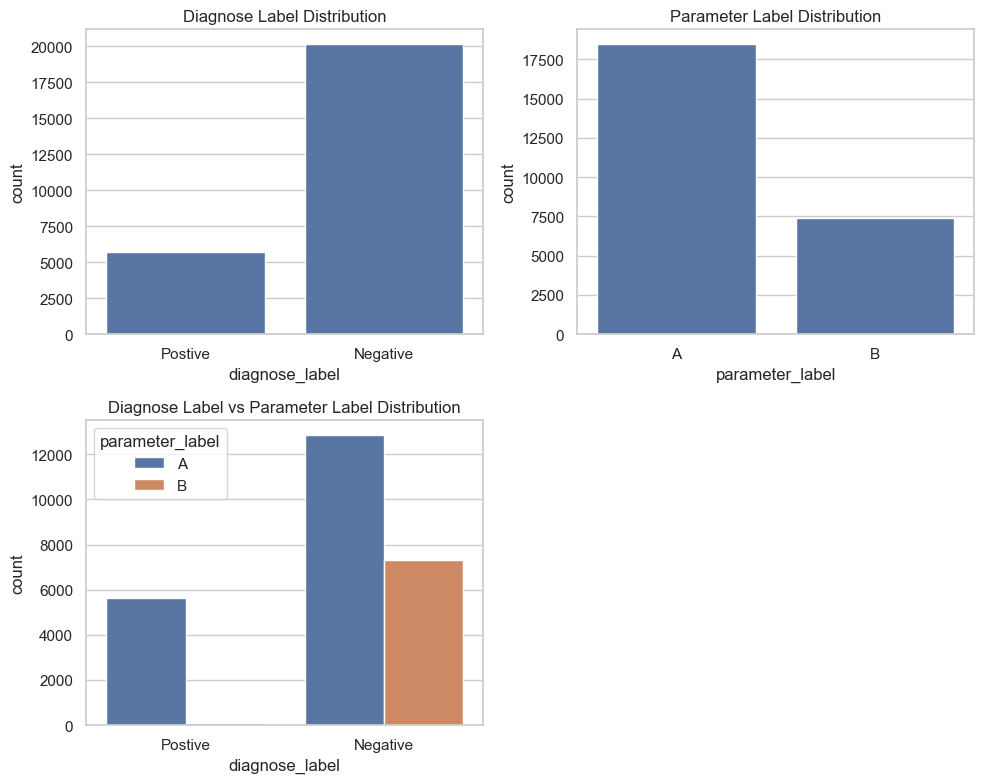

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 創建一個示例DataFrame，這裡需要根據你的實際資料來載入或創建DataFrame
data = pd.concat([df_in_diagnose, df_in_no_finding], axis=0)
data.loc[data['parameter_label'] == 1, 'parameter_label'] = 'A'
data.loc[data['parameter_label'] != 'A', 'parameter_label'] = 'B'
data.loc[data['diagnose_label'] == 1, 'diagnose_label'] = 'Postive'
data.loc[data['diagnose_label'] != 'Postive', 'diagnose_label'] = 'Negative'

# 創建一個四宮格的子圖
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# 將diagnose_label的分佈繪製在左上角子圖中
sns.countplot(data=data, x='diagnose_label', ax=axs[0, 0])
axs[0, 0].set_title('Diagnose Label Distribution')

# 將parameter_label的分佈繪製在右上角子圖中
sns.countplot(data=data, x='parameter_label', ax=axs[0, 1])
axs[0, 1].set_title('Parameter Label Distribution')

# 將diagnose_label和parameter_label的組合分佈繪製在左下角子圖中
sns.countplot(data=data, x='diagnose_label', hue='parameter_label', ax=axs[1, 0])
axs[1, 0].set_title('Diagnose Label vs Parameter Label Distribution')

# 移除右下角子圖
fig.delaxes(axs[1,1])

plt.tight_layout()
plt.show()


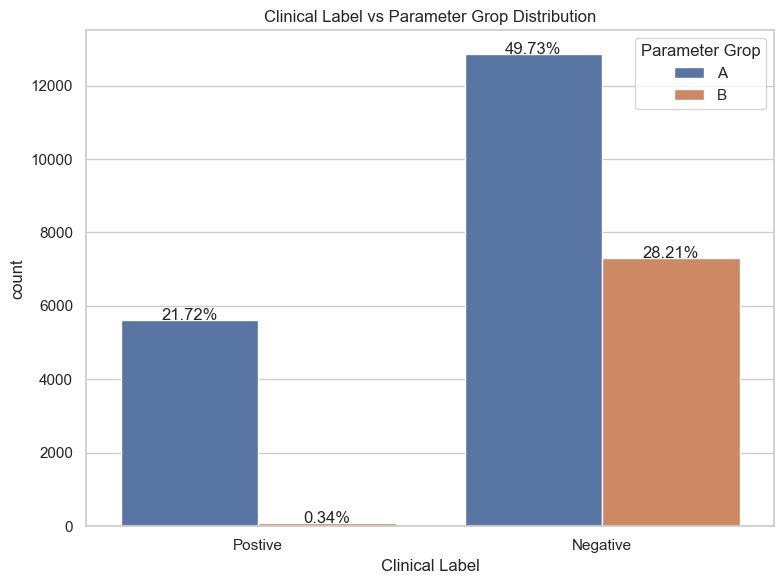

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))
data['Parameter Grop'] = data['parameter_label']
data['Clinical Label'] = data['diagnose_label']
# 將diagnose_label和parameter_label的組合分佈繪製在左下角子圖中
sns.countplot(data=data, x='Clinical Label', hue='Parameter Grop', ax=ax)

total = float(len(data))
print()
for p in ax.patches:
    height = p.get_height()
    if(height == 0): 
        continue
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1, '{:.2f}%'.format((height / total) * 100), ha="center")
ax.set_title('Clinical Label vs Parameter Grop Distribution')

plt.tight_layout()
plt.show()

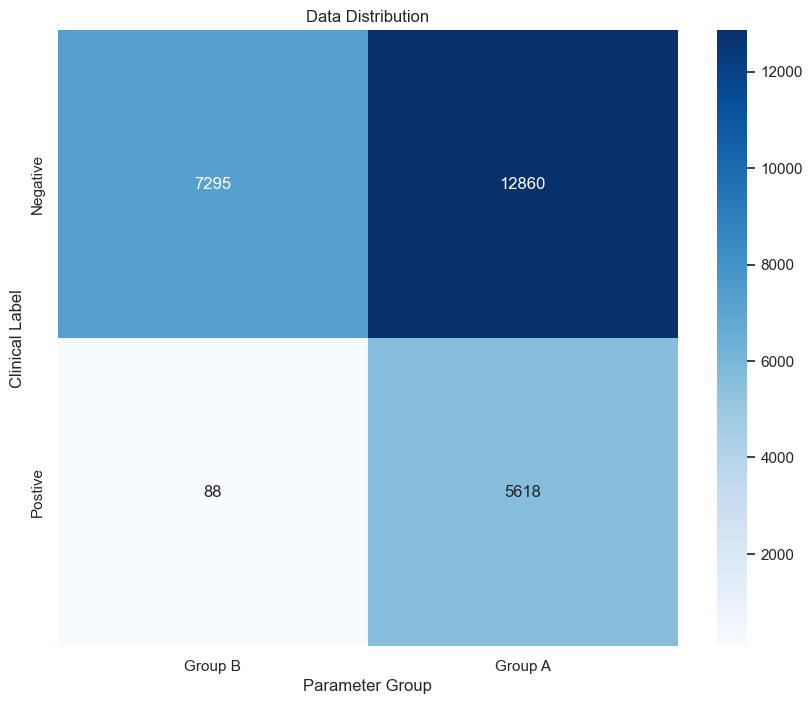

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假設你的資料中有10個不同的診斷標籤和10個不同的參數標籤
num_diagnoses = 2
num_parameters = 2
diagnose_labels = ['Negative', 'Postive']
parameter_labels = ['Group B', 'Group A']
df = pd.concat([df_in_diagnose, df_in_no_finding], axis=0)
# 初始化一個10x10的矩陣，用於計算每個組合的計數
confusion_matrix = [[0]*len(parameter_labels) for _ in range(len(diagnose_labels))]

# 根據每一行資料更新矩陣的計數
for _, row in df.iterrows():
    diagnosis = row['diagnose_label']
    parameter = row['parameter_label']
    confusion_matrix[diagnosis][parameter] += 1

# 繪製熱圖
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=parameter_labels, yticklabels=diagnose_labels)
plt.xlabel('Parameter Group')
plt.ylabel('Clinical Label')
plt.title('Data Distribution')
plt.show()


In [57]:
def plot_a_function(input_list):
    for i in range(input_list):
        diagnosis = input_list[i]['diagnose_label']
        parameter = input_list[i]['parameter_label']
        confusion_matrix[diagnosis][parameter] += 1

    # 繪製熱圖
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=parameter_labels, yticklabels=diagnose_labels)
    plt.xlabel('Parameter Group')
    plt.ylabel('Clinical Label')
    plt.title('Data Distribution')
    plt.show()

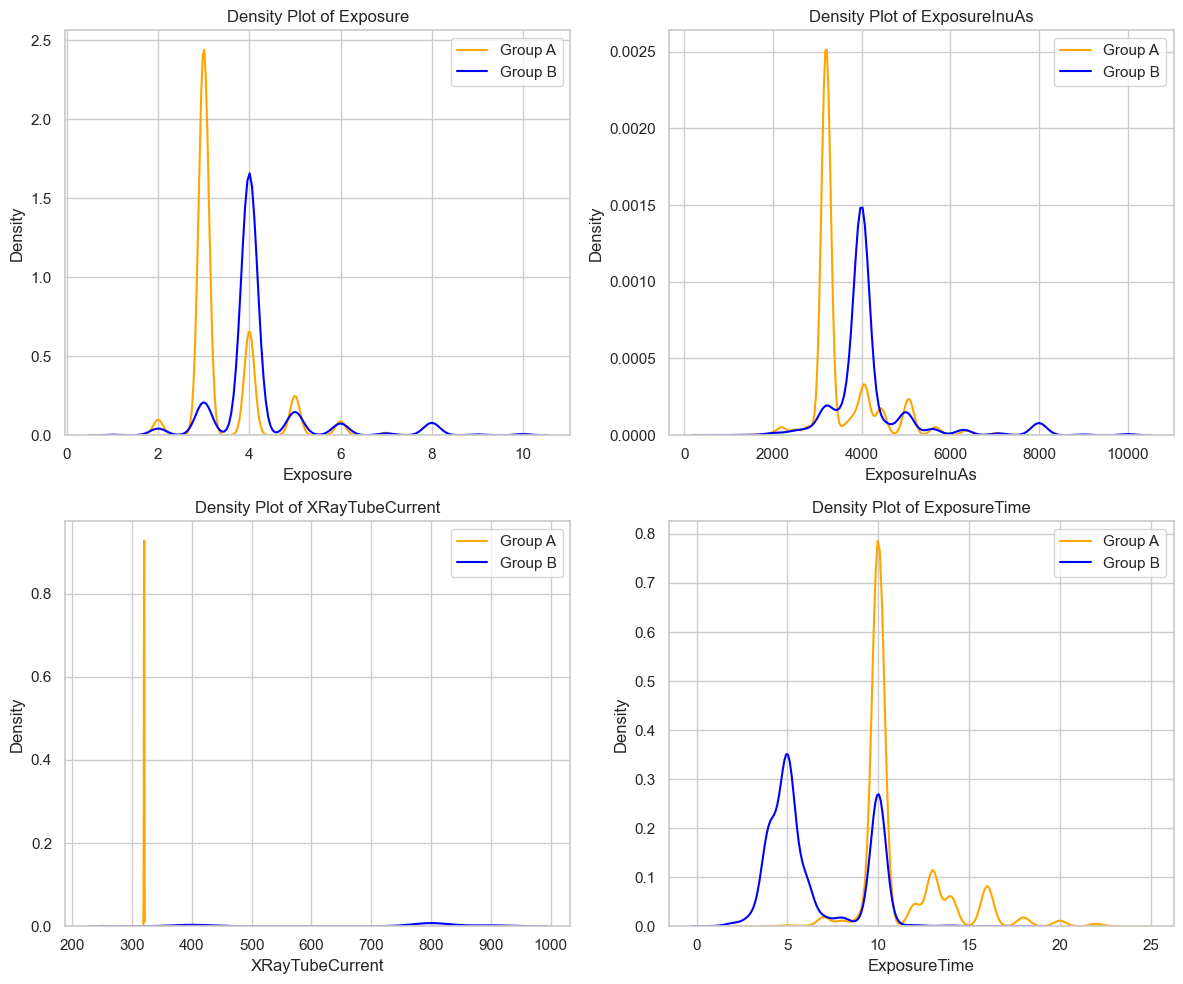

In [58]:
df_0 = df[df['parameter_label'] == 0]
df_1 = df[df['parameter_label'] == 1]



for feature in ['Exposure', 'ExposureInuAs', 'XRayTubeCurrent', 'ExposureTime']:
    df_0 = df_0[np.abs(df_0[feature] - df_0[feature].mean()) <= (5 * df_0[feature].std())]
    df_1 = df_1[np.abs(df_1[feature] - df_1[feature].mean()) <= (5 * df_1[feature].std())]
        

# 設置畫圖風格
sns.set(style="whitegrid")
# 畫每個特徵的密度估計線
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 調整子圖大小和數量
for i, feature in enumerate(['Exposure', 'ExposureInuAs', 'XRayTubeCurrent', 'ExposureTime']):
    ax = axes[i//2, i%2]  # 定位子圖位置
    sns.kdeplot(data=df_1, x=feature, ax=ax, label='Group A', color='orange')  # 繪製標籤 1 的密度線
    sns.kdeplot(data=df_0, x=feature, ax=ax, label='Group B', color='blue')  # 繪製標籤 0 的密度線
    
    ax.set_title(f'Density Plot of {feature}')  # 設置標題
    ax.legend()  # 添加圖例
plt.tight_layout()
plt.show()

In [12]:
data.columns

Index(['subject_id', 'dicom', 'StudyID', 'path', 'Exposure', 'ExposureInuAs',
       'XRayTubeCurrent', 'ExposureTime', 'race', 'gender', 'admission_type',
       'admission_location', 'insurance', 'languagea', 'anchor_age',
       'StudyDate', 'diagnose_label', 'parameter_label', 'Parameter Grop',
       'Clinical Label'],
      dtype='object')

In [60]:
from tableone import TableOne
filtered_df = data
#filtered_df['sex'] = filtered_df['sex'].map({'Male': 1, 'Female': 0})
# 转换性别为数值型，男性为1，女性为0
#filtered_df['sex'] = filtered_df['sex'].map({'Male': 1, 'Female': 0})

# 将相关字段转换为数值型
filtered_df['ExposureTime'] = pd.to_numeric(filtered_df['ExposureTime'], errors='coerce')
filtered_df['XRayTubeCurrent'] = pd.to_numeric(filtered_df['XRayTubeCurrent'], errors='coerce')
filtered_df['race'] = np.where(filtered_df['race'].str.contains('WHITE'), 'WHITE',
             np.where(filtered_df['race'].str.contains('BLACK'), 'BLACK',
             np.where(filtered_df['race'].str.contains('HISPANIC/LATINO'), 'HISPANIC/LATINO',
             np.where(filtered_df['race'].str.contains('ASIAN'), 'ASIAN',
             'OTHERS'))))



# 使用tableone创建统计表
columns_to_include = [ 'race', 'gender', 'ExposureTime', 'XRayTubeCurrent', 'Exposure', 'ExposureInuAs','admission_location','insurance', 'languagea','StudyDate','anchor_age','Parameter Grop','Clinical Label']
table = TableOne(filtered_df, columns=columns_to_include, categorical=['race', 'gender','admission_location','insurance', 'languagea','Parameter Grop','Clinical Label'],groupby=['Clinical Label'], nonnormal=[ 'Exposure', 'ExposureInuAs', 'ExposureIndex','StudyDate','anchor_age'], pval=True)

print(table.tabulate(tablefmt="grid"))

+-------------------------------+----------------------------------------+-----------+------------------------------------+------------------------------------+------------------------------------+-----------+
|                               |                                        | Missing   | Overall                            | Negative                           | Postive                            | P-Value   |
+===============================+========================================+===========+====================================+====================================+====================================+===========+
| n                             |                                        |           | 25861                              | 20155                              | 5706                               |           |
+-------------------------------+----------------------------------------+-----------+------------------------------------+------------------------------------+

/opt/miniconda3/envs/MIT_test/lib/python3.9/site-packages/tableone/tableone.py:927: FutureWarning: The provided callable <function mean at 0x10890e310> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_cont = pd.pivot_table(cont_data,
/opt/miniconda3/envs/MIT_test/lib/python3.9/site-packages/tableone/tableone.py:927: FutureWarning: The provided callable <function median at 0x108fc4c10> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_cont = pd.pivot_table(cont_data,
/opt/miniconda3/envs/MIT_test/lib/python3.9/site-packages/tableone/tableone.py:927: FutureWarning: The provided callable <built-in function min> is currently using DataFrameGroupBy.min. In a future version of pandas, the provided callable will be used directly. To

In [81]:
latex_output = table.to_latex()
print(latex_output)

# 如果需要，可以将 LaTeX 代码保存到文件中
with open('Pneumothorax_tableone_output.tex', 'w') as f:
    f.write(latex_output)

\begin{tabular}{llllll}
\toprule
 &  & \multicolumn{4}{r}{Grouped by diagnose_label} \\
 &  & Missing & Overall & Negative & Postive \\
\midrule
n &  &  & 11412 & 5706 & 5706 \\
\cline{1-6}
\multirow[t]{5}{*}{race, n (%)} & ASIAN & 0 & 414 (3.6) & 170 (3.0) & 244 (4.3) \\
 & BLACK &  & 1481 (13.0) & 985 (17.3) & 496 (8.7) \\
 & HISPANIC/LATINO &  & 355 (3.1) & 207 (3.6) & 148 (2.6) \\
 & OTHERS &  & 1858 (16.3) & 841 (14.7) & 1017 (17.8) \\
 & WHITE &  & 7304 (64.0) & 3503 (61.4) & 3801 (66.6) \\
\cline{1-6}
\multirow[t]{2}{*}{gender, n (%)} & F & 0 & 4905 (43.0) & 2638 (46.2) & 2267 (39.7) \\
 & M &  & 6507 (57.0) & 3068 (53.8) & 3439 (60.3) \\
\cline{1-6}
ExposureTime, mean (SD) &  & 0 & 10.8 (11.0) & 10.5 (12.7) & 11.2 (8.9) \\
\cline{1-6}
XRayTubeCurrent, mean (SD) &  & 0 & 392.3 (174.2) & 459.6 (221.2) & 324.9 (52.1) \\
\cline{1-6}
Exposure, median [Q1,Q3] &  & 0 & 3.0 [3.0,4.0] & 4.0 [3.0,4.0] & 3.0 [3.0,4.0] \\
\cline{1-6}
ExposureInuAs, median [Q1,Q3] &  & 0 & 3200.0 [3200.0,40

# pickfrom available data

In [3]:
with open('./image_dic_list/diagnose_dic_list_Pneumothorax_98.pkl', 'rb') as f:
    diagnose_dic_list = pickle.load(f)
with open('./image_dic_list/no_finding_dic_Pneumothorax.pkl_98_all.pkl', 'rb') as f:
    no_finding_dic_list = pickle.load(f)

In [4]:
import random

random.seed(42)
no_finding_dic_list = random.sample(no_finding_dic_list, len(diagnose_dic_list))

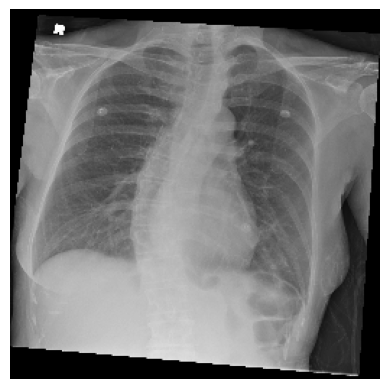

In [5]:
def draw_CR(image_data):
    
    plt.imshow(image_data, cmap='gray') 
    plt.axis('off')
    plt.show()
    
draw_CR(no_finding_dic_list[22]['image'])

In [6]:
image_list = []
exp_label = []
cli_label = []
imb_label = []

for i in range(len(diagnose_dic_list)):
    image_list.append(diagnose_dic_list[i]['image'])
for i in range(len(no_finding_dic_list)):
    image_list.append(no_finding_dic_list[i]['image'])
    
for i in range(len(diagnose_dic_list)):
    exp_label.append(diagnose_dic_list[i]['parameter_label'])
for i in range(len(no_finding_dic_list)):
    exp_label.append(no_finding_dic_list[i]['parameter_label'])
    
for i in range(len(diagnose_dic_list)):
    cli_label.append(diagnose_dic_list[i]['diagnose_label'])
for i in range(len(no_finding_dic_list)):
    cli_label.append(no_finding_dic_list[i]['diagnose_label'])
    
count = 0

for i in range(len(diagnose_dic_list)):
    if(diagnose_dic_list[i]['parameters'][2]<=320):
        if(exp_label[i]!=1):
            print("!!!!")
        count+=1
     
for i in range(len(no_finding_dic_list)):
    if(no_finding_dic_list[i]['parameters'][2]<=320):
        if(exp_label[len(diagnose_dic_list)+i]!=1):
            print("!!!!")
        count+=1   

print(count)


9270


In [7]:
print(Counter(cli_label))
print(Counter(exp_label))

Counter({1: 5706, 0: 5706})
Counter({1: 9270, 0: 2142})


# Train parameter label model

In [37]:
import albumentations as A
def balance_classes(images, labels):
    # 找出每個類別的索引
    class0_indices = np.where(labels == 0)[0]
    class1_indices = np.where(labels == 1)[0]

    # 平衡類別
    if len(class0_indices) > len(class1_indices):
        extra_indices = np.random.choice(class0_indices, size=len(class1_indices), replace=False)
        balanced_indices = np.concatenate([class1_indices, extra_indices])
    else:
        extra_indices = np.random.choice(class1_indices, size=len(class0_indices), replace=False)
        balanced_indices = np.concatenate([class0_indices, extra_indices])

    return images[balanced_indices], labels[balanced_indices]

def augment_images(image_list):
    # 定義增強變換
    transform = A.Compose([
        A.Rotate(limit=15, p=0.5),
        A.HorizontalFlip(p=0.5),
        #A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.Resize(height=256, width=256)  # 確保影像大小一致
    ])

    # 應用增強
    augmented_images = np.zeros_like(image_list)
    for idx in range(len(image_list)):
        augmented_images[idx] = transform(image=image_list[idx])['image']

    return augmented_images

In [15]:
X = np.array(image_list) 
X = X.reshape((-1, 256, 256, 1)) 
y = np.array(cli_label) 



X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [13]:


# 平衡類別
#balanced_images, balanced_labels = balance_classes(X_train, y_train)

# 應用增強
X_train_new = augment_images(X_train)


In [54]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

def build_resnet50_v2_model(input_shape=(256, 256, 1), num_classes=3):
    model = models.Sequential()
    
    model.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation='bilinear'))
    
    model.add(layers.Conv2D(3, (3, 3), padding='same'))
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False 
    model.add(base_model)
    
    model.add(layers.GlobalAveragePooling2D())
    
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model
model_resnet50_v2 = build_resnet50_v2_model()
model_resnet50_v2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auroc', curve='ROC')  # AUROC 指標
    ]
)


In [ ]:
model_resnet50_v2.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

model_resnet50_v2.evaluate(X_test, y_test)

In [48]:
#model_resnet50_v2.save('./Models/Pneumothorax/Clinical_model_00') 

INFO:tensorflow:Assets written to: ./Models/Pneumothorax/Clinical_model_00/assets


INFO:tensorflow:Assets written to: ./Models/Pneumothorax/Clinical_model_00/assets


In [49]:
print(len(exp_label),len(cli_label))

11412 11412


In [18]:
exp_y = np.array(exp_label) 
X = np.array(image_list) 
X = X.reshape((-1, 256, 256, 1)) 
X_train, X_temp, exp_y_train, y_temp = train_test_split(X, exp_y, test_size=0.3, random_state=42)
X_val, X_test, exp_y_val, exp_y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

group_a_image_list =[]
group_a_cli_label_list = []
group_b_image_list =[]
group_b_cli_label_list = []



In [19]:
for i in range(len(exp_y_val)):
    if(exp_y_val[i]==1):
        group_a_image_list.append(X_val[i])
        group_a_cli_label_list.append(y_val[i])
    else:
        group_b_image_list.append(X_val[i])
        group_b_cli_label_list.append(y_val[i])
        
for i in range(len(exp_y_val)):
    if(exp_y_val[i]==1):
        group_a_image_list.append(X_test[i])
        group_a_cli_label_list.append(y_test[i])
    else:
        group_b_image_list.append(X_test[i])
        group_b_cli_label_list.append(y_test[i])
        
X = np.array(group_a_image_list) 
group_a_image = X.reshape((-1, 256, 256, 1)) 
group_a_cli_label= np.array(group_a_cli_label_list) 


X = np.array(group_b_image_list) 
group_b_image = X.reshape((-1, 256, 256, 1)) 
group_b_cli_label= np.array(group_b_cli_label_list) 

In [21]:
print(len(group_a_cli_label),len(group_b_cli_label))

2728 696


In [64]:
model_resnet50_v2.evaluate(group_a_image, group_a_cli_label)
model_resnet50_v2.evaluate(group_b_image, group_b_cli_label)

44/44 [==============================] - 45s 1s/step - loss: 0.3613 - accuracy: 0.8348 - auroc: 0.8952


[0.36126941442489624, 0.834770143032074, 0.8952245116233826]

Bad pipe message: %s [b"\xcc\xb2@\x8c\x919\xa6.\xbb\xed\\\nA^\xe9\xef\x02D [\xb3\xa7'\xd7v\x15\xdb)\x96\xf3\xb9\xa8\xd4\x91\t3j\x83\xf3\x97\xcd\xf8\xe2-\xcc\x9d\xd5\x1f#\xb7\xfa\x00 \xda\xda\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x063\n\n\x00\x00\x00\x1b\x00\x03\x02\x00\x02\x00\x12\x00\x00Di\x00\x05\x00\x03\x02h2\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06\x01\x00-\x00\x02\x01\x01\x00+\x00\x07\x06ZZ\x03\x04\x03\x03\x00\x05\x00\x05\x01"]
Bad pipe message: %s [b'\xda%@\x87\xfaE\x16\xb5\x9d#\xbd\x80V\xa4p\x9ei\xe2 p[\xa1\x8c\x96\xd2M}\xb5\x00\xb2f\xad*\xb0fT\x15', b'\xbaYG\x0f\x8e_\x9f?\xdfLkU\x00 \xaa\xaa\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x06sJJ\x00\x00\x00\n\x00\x0c\x00\n\xba\xbac\x99\x00\x1d\x00\x17\x00\x18Di\x00\x05\x00\x03\x02h2\x00-\x00\x02\x01\x01\x00\x05\x00

In [61]:
model_resnet50_v2.evaluate(group_a_image, group_a_cli_label)
model_resnet50_v2.evaluate(group_b_image, group_b_cli_label)

44/44 [==============================] - 37s 829ms/step - loss: 0.3613 - accuracy: 0.8348 - auroc: 0.8952


[0.36126941442489624, 0.834770143032074, 0.8952245116233826]

In [38]:
X_train_new = augment_images(X_train)

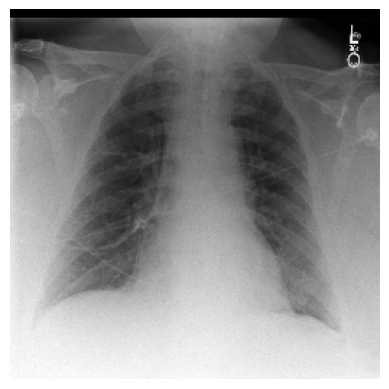

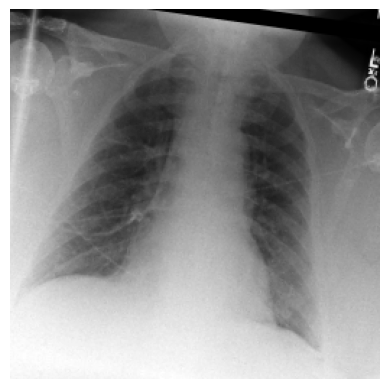

In [53]:
num  = 9

draw_CR(X_train[num])
draw_CR(X_train_new[num])

# Experiment

In [55]:
for i in range(10):
    X_train_new = augment_images(X_train)
    model_resnet50_v2.fit(X_train_new, y_train, epochs=1, validation_data=(X_val, y_val))
    print("test:")
    model_resnet50_v2.evaluate(X_test, y_test)
    print("group a:")
    model_resnet50_v2.evaluate(group_a_image, group_a_cli_label)
    print("group b:")
    model_resnet50_v2.evaluate(group_b_image, group_b_cli_label)
    

250/250 [==============================] - 635s 3s/step - loss: 0.6961 - accuracy: 0.5632 - auroc: 0.5829 - val_loss: 0.6534 - val_accuracy: 0.6279 - val_auroc: 0.6798
test:
54/54 [==============================] - 44s 806ms/step - loss: 0.6550 - accuracy: 0.6238 - auroc: 0.6762
group a:
86/86 [==============================] - 69s 798ms/step - loss: 0.6699 - accuracy: 0.5964 - auroc: 0.6362
group b:
22/22 [==============================] - 18s 795ms/step - loss: 0.5928 - accuracy: 0.7414 - auroc: 0.7784


: 